# Image Captioning 

## 1. Introduction
Caption generation is a challenging artificial intelligence problem where a textual description must be generated for a given photograph.

It requires both methods from computer vision to understand the content of the image and a language model from the field of natural language processing to turn the understanding of the image into words in the right order. Recently, deep learning methods have achieved state-of-the-art results on examples of this problem.

## 2. Prepare the Photo Data
We will use a pre-trained model to interpret the content of the photos.

There are many models to choose from. In this case, we will use the Oxford Visual Geometry Group, or VGG, model that won the ImageNet competition in 2014. Learn more about the model here:
http://www.robots.ox.ac.uk/~vgg/research/very_deep/

Keras provides this pre-trained model directly. Note, the first time you use this model, Keras will download the model weights from the Internet, which are about 500 Megabytes. This may take a few minutes depending on your internet connection.

We could use this model as part of a broader image caption model. The problem is, it is a large model and running each photo through the network every time we want to test a new language model configuration (downstream) is redundant.

Instead, we can pre-compute the “photo features” using the pre-trained model and save them to file. We can then load these features later and feed them into our model as the interpretation of a given photo in the dataset. It is no different to running the photo through the full VGG model; it is just we will have done it once in advance.

This is an optimization that will make training our models faster and consume less memory.

We can load the VGG model in Keras using the VGG class. We will remove the last layer from the loaded model, as this is the model used to predict a classification for a photo. We are not interested in classifying images, but we are interested in the internal representation of the photo right before a classification is made. These are the “features” that the model has extracted from the photo.

Keras also provides tools for reshaping the loaded photo into the preferred size for the model (e.g. 3 channel 224 x 224 pixel image).

Below is a function named extract_features() that, given a directory name, will load each photo, prepare it for VGG, and collect the predicted features from the VGG model. The image features are a 1-dimensional 4,096 element vector.

### 2A. The function returns a dictionary of image identifier to image features.
At the end of the run, you will have the extracted features stored in ‘features.pkl‘ for later use. This file will be about 127 Megabytes in size.

In [2]:
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
 
# extract features from each photo in the directory
def extract_features(directory):
   # load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# summarize
	print(model.summary())
	# extract features from each photo
	features = dict()
	for name in listdir(directory):
		# load an image from file
		filename = directory + '/' + name
		image = load_img(filename, target_size=(224, 224))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the VGG model
		image = preprocess_input(image)
		# get features
		feature = model.predict(image, verbose=0)
		# get image id
		image_id = name.split('.')[0]
		# store feature
		features[image_id] = feature
		print('>%s' % name)
	return features
 
# extract features from all images
directory = 'Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## 3. Prepare Text Data

### 3A. Clean the Text Data

In [7]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
filename = 'Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)

Each photo has a unique identifier. This identifier is used on the photo filename and in the text file of descriptions.

Next, we will step through the list of photo descriptions. Below defines a function load_descriptions() that, given the loaded document text, will return a dictionary of photo identifiers to descriptions. Each photo identifier maps to a list of one or more textual descriptions.

In [8]:
# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping
 
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


Next, we need to clean the description text. The descriptions are already tokenized and easy to work with.

We will clean the text in the following ways in order to reduce the size of the vocabulary of words we will need to work with:

- Convert all words to lowercase.
- Remove all punctuation.
- Remove all words that are one character or less in length (e.g. ‘a’).
- Remove all words with numbers in them.
- Below defines the clean_descriptions() function that, given the dictionary of image identifiers to  descriptions, steps through each description and cleans the text.

In [10]:
import string
 
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)
 
# clean descriptions
clean_descriptions(descriptions)

Once cleaned, we can summarize the size of the vocabulary.

Ideally, we want a vocabulary that is both expressive and as small as possible. A smaller vocabulary will result in a smaller model that will train faster.

For reference, we can transform the clean descriptions into a set and print its size to get an idea of the size of our dataset vocabulary.

In [11]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc
 
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8763


Finally, we can save the dictionary of image identifiers and descriptions to a new file named descriptions.txt, with one image identifier and description per line.

Below defines the save_descriptions() function that, given a dictionary containing the mapping of identifiers to descriptions and a filename, saves the mapping to file.

In [12]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()
 
# save descriptions
save_descriptions(descriptions, 'descriptions.txt')


filename = 'Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


Finally, the clean descriptions are written to ‘descriptions.txt‘.

## 4. Develop Deep Learning Model

In this section, we will define the deep learning model and fit it on the training dataset.

This section is divided into the following parts:

- Loading Data.
- Defining the Model.
- Fitting the Model.
- Complete Example.

### 4A. Loading Data

First, we must load the prepared photo and text data so that we can use it to fit the model.

We are going to train the data on all of the photos and captions in the training dataset. While training, we are going to monitor the performance of the model on the development dataset and use that performance to decide when to save models to file.

The train and development dataset have been predefined in the Flickr_8k.trainImages.txt and Flickr_8k.devImages.txt files respectively, that both contain lists of photo file names. From these file names, we can extract the photo identifiers and use these identifiers to filter photos and descriptions for each set.

The function load_set() below will load a pre-defined set of identifiers given the train or development sets filename.

In [1]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

Now, we can load the photos and descriptions using the pre-defined set of train or development identifiers.

Below is the function load_clean_descriptions() that loads the cleaned text descriptions from ‘descriptions.txt‘ for a given set of identifiers and returns a dictionary of identifiers to lists of text descriptions.

The model we will develop will generate a caption given a photo, and the caption will be generated one word at a time. The sequence of previously generated words will be provided as input. Therefore, we will need a ‘first word’ to kick-off the generation process and a ‘last word‘ to signal the end of the caption.

We will use the strings ‘startseq‘ and ‘endseq‘ for this purpose. These tokens are added to the loaded descriptions as they are loaded. It is important to do this now before we encode the text so that the tokens are also encoded correctly.

In [14]:
from pickle import load
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

Next, we can load the photo features for a given dataset.

Below defines a function named load_photo_features() that loads the entire set of photo descriptions, then returns the subset of interest for a given set of photo identifiers.

This is not very efficient; nevertheless, this will get us up and running quickly.

In [15]:
# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

Let's test what we have build thus far

In [16]:
# load training dataset (6K)
filename = 'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


The description text will need to be encoded to numbers before it can be presented to the model as in input or compared to the model’s predictions.

The first step in encoding the data is to create a consistent mapping from words to unique integer values. Keras provides the Tokenizer class that can learn this mapping from the loaded description data.

Below defines the to_lines() to convert the dictionary of descriptions into a list of strings and the create_tokenizer() function that will fit a Tokenizer given the loaded photo description text.

In [17]:
from keras.preprocessing.text import Tokenizer
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7579


We can now encode the text.

Each description will be split into words. The model will be provided one word and the photo and generate the next word. Then the first two words of the description will be provided to the model as input with the image to generate the next word. This is how the model will be trained.

For example, the input sequence “little girl running in field” would be split into 6 input-output pairs to train the model:

X1,		X2 (text sequence), 						y (word)
photo	startseq, 									little
photo	startseq, little,							girl
photo	startseq, little, girl, 					running
photo	startseq, little, girl, running, 			in
photo	startseq, little, girl, running, in, 		field
photo	startseq, little, girl, running, in, field, endseq


Later, when the model is used to generate descriptions, the generated words will be concatenated and recursively provided as input to generate a caption for an image.

The function below named create_sequences(), given the tokenizer, a maximum sequence length, and the dictionary of all descriptions and photos, will transform the data into input-output pairs of data for training the model. There are two input arrays to the model: one for photo features and one for the encoded text. There is one output for the model which is the encoded next word in the text sequence.

The input text is encoded as integers, which will be fed to a word embedding layer. The photo features will be fed directly to another part of the model. The model will output a prediction, which will be a probability distribution over all words in the vocabulary.

The output data will therefore be a one-hot encoded version of each word, representing an idealized probability distribution with 0 values at all word positions except the actual word position, which has a value of 1.

In [18]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each image identifier
	for key, desc_list in descriptions.items():
		# walk through each description for the image
		for desc in desc_list:
			# encode the sequence
			seq = tokenizer.texts_to_sequences([desc])[0]
			# split one sequence into multiple X,y pairs
			for i in range(1, len(seq)):
				# split into input and output pair
				in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				# encode output sequence
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				# store
				X1.append(photos[key][0])
				X2.append(in_seq)
				y.append(out_seq)
	return array(X1), array(X2), array(y)

We will need to calculate the maximum number of words in the longest description. A short helper function named max_length() is defined below.

In [19]:
# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

We now have enough to load the data for the training and development datasets and transform the loaded data into input-output pairs for fitting a deep learning model.

## 5. Defining A Model

We will define a deep learning based on the “merge-model” described by Marc Tanti, et al. in their 2017 papers:
- https://arxiv.org/abs/1703.09137
- https://arxiv.org/abs/1708.02043

For a gentle introduction to this architecture, see the post:
https://machinelearningmastery.com/caption-generation-inject-merge-architectures-encoder-decoder-model/

We will describe the model in three parts:

- Photo Feature Extractor. This is a 16-layer VGG model pre-trained on the ImageNet dataset. We have pre-processed the photos with the VGG model (without the output layer) and will use the extracted features predicted by this model as input.
- Sequence Processor. This is a word embedding layer for handling the text input, followed by a Long Short-Term Memory (LSTM) recurrent neural network layer.
- Decoder (for lack of a better name). Both the feature extractor and sequence processor output a fixed-length vector. These are merged together and processed by a Dense layer to make a final prediction.

The Photo Feature Extractor model expects input photo features to be a vector of 4,096 elements. These are processed by a Dense layer to produce a 256 element representation of the photo.

The Sequence Processor model expects input sequences with a pre-defined length (34 words) which are fed into an Embedding layer that uses a mask to ignore padded values. This is followed by an LSTM layer with 256 memory units.

Both the input models produce a 256 element vector. Further, both input models use regularization in the form of 50% dropout. This is to reduce overfitting the training dataset, as this model configuration learns very fast.

The Decoder model merges the vectors from both input models using an addition operation. This is then fed to a Dense 256 neuron layer and then to a final output Dense layer that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

The function below named define_model() defines and returns the model ready to be fit.

In [26]:
# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	print(model.summary())
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

### Fitting the model

Now that we know how to define the model, we can fit it on the training dataset.

The model learns fast and quickly overfits the training dataset. For this reason, we will monitor the skill of the trained model on the holdout development dataset. When the skill of the model on the development dataset improves at the end of an epoch, we will save the whole model to file.

At the end of the run, we can then use the saved model with the best skill on the training dataset as our final model.

We can do this by defining a ModelCheckpoint in Keras and specifying it to monitor the minimum loss on the validation dataset and save the model to a file that has both the training and validation loss in the filename.

### The complete fitting exercise is done here

In [ ]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint


# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each image identifier
	for key, desc_list in descriptions.items():
		# walk through each description for the image
		for desc in desc_list:
			# encode the sequence
			seq = tokenizer.texts_to_sequences([desc])[0]
			# split one sequence into multiple X,y pairs
			for i in range(1, len(seq)):
				# split into input and output pair
				in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				# encode output sequence
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				# store
				X1.append(photos[key][0])
				X2.append(in_seq)
				y.append(out_seq)
	return array(X1), array(X2), array(y)

# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	print(model.summary())
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

# train dataset

# load training dataset (6K)
filename = 'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

# dev dataset

# load test set
filename = 'Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)

# fit model

# define the model
model = define_model(vocab_size, max_length)
# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# fit model
model.fit([X1train, X2train], ytrain, epochs=20, verbose=1, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))


Using TensorFlow backend.


Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 306404 samples, validate on 50903 samples
Epoch 1/20
306404/306404 [==============================] - 2514s 8ms/step - loss: 4.5301 - val_loss: 4.0734

Epoch 00001: val_loss improved from inf to 4.07341, saving model to model-ep001-loss4.530-val_loss4.073.h5
Epoch 2/20
306404/306404 [==============================] - 2622s 9ms/step - loss: 3.8555 - val_loss: 3.9213

Epoch 00002: val_loss improved from 4.07341 to 3.92129, saving model to model-ep002-loss3.855-val_loss3.921.h5
Epoch 3/20
306404/306404 [==============================] - 2538s 8ms/step - loss: 3.6418 - val_loss: 3.8823

Epoch 00003: val_loss improved from 3.92129 to 3.88232, saving model to model-ep003-loss3.642-val_loss3.882.h5
Epoch 4/20
227328/306404 [=====================>........] - ETA: 11:43 - loss: 3.5286

## Evaluate Model
Once the model is fit, we can evaluate the skill of its predictions on the holdout test dataset.

We will evaluate a model by generating descriptions for all photos in the test dataset and evaluating those predictions with a standard cost function.

First, we need to be able to generate a description for a photo using a trained model.

This involves passing in the start description token ‘startseq‘, generating one word, then calling the model recursively with generated words as input until the end of sequence token is reached ‘endseq‘ or the maximum description length is reached.

The function below named generate_desc() implements this behavior and generates a textual description given a trained model, and a given prepared photo as input. It calls the function word_for_id() in order to map an integer prediction back to a word.

In [ ]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

We will generate predictions for all photos in the test dataset and in the train dataset.

The function below named evaluate_model() will evaluate a trained model against a given dataset of photo descriptions and photo features. The actual and predicted descriptions are collected and evaluated collectively using the corpus BLEU score that summarizes how close the generated text is to the expected text.

In [ ]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU scores are used in text translation for evaluating translated text against one or more reference translations.

Here, we compare each generated description against all of the reference descriptions for the photograph. We then calculate BLEU scores for 1, 2, 3 and 4 cumulative n-grams.

You can learn more about the BLEU score here:
https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

The NLTK Python library implements the BLEU score calculation in the corpus_bleu() function. A higher score close to 1.0 is better, a score closer to zero is worse.

We can put all of this together with the functions from the previous section for loading the data. We first need to load the training dataset in order to prepare a Tokenizer so that we can encode generated words as input sequences for the model. It is critical that we encode the generated words using exactly the same encoding scheme as was used when training the model.

We then use these functions for loading the test dataset.

The complete example is listed below.

In [1]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
 
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)
 
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions
 
# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features
 
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)
 
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text
 
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
 
# prepare tokenizer on train set
 
# load training dataset (6K)
filename = 'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
 
# prepare test set
 
# load test set
filename = 'Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
 
# load the model
filename = 'model-ep003-loss3.642-val_loss3.882.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Using TensorFlow backend.


Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000


/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


BLEU-1: 0.560461
BLEU-2: 0.295374
BLEU-3: 0.196870
BLEU-4: 0.088296


Running the example prints the BLEU scores.

We can see that the scores fit within and close to the top of the expected range of a skillful model on the problem. The chosen model configuration is by no means optimized.

## Generate New Captions

Now that we know how to develop and evaluate a caption generation model, how can we use it?

Almost everything we need to generate captions for entirely new photographs is in the model file.

We also need the Tokenizer for encoding generated words for the model while generating a sequence, and the maximum length of input sequences, used when we defined the model (e.g. 34).

We can hard code the maximum sequence length. With the encoding of text, we can create the tokenizer and save it to a file so that we can load it quickly whenever we need it without needing the entire Flickr8K dataset. An alternative would be to use our own vocabulary file and mapping to integers function during training.

We can create the Tokenizer as before and save it as a pickle file tokenizer.pkl. The complete example is listed below.

In [2]:
from keras.preprocessing.text import Tokenizer
from pickle import dump
 
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)
 
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions
 
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# load training dataset (6K)
filename = 'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Using TensorFlow backend.


Dataset: 6000
Descriptions: train=6000


We can now load the tokenizer whenever we need it without having to load the entire training dataset of annotations.

Now, let’s generate a description for a new photograph.

We will generate a description for it using our model.

Download the photograph and save it to your local directory with the filename “example.jpg“.

First, we must load the Tokenizer from tokenizer.pkl and define the maximum length of the sequence to generate, needed for padding inputs.

In [5]:
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34

Then we must load the model, as before.

In [6]:
# load the model
model = load_model('model-ep003-loss3.642-val_loss3.882.h5')

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Next, we must load the photo we which to describe and extract the features.

We could do this by re-defining the model and adding the VGG-16 model to it, or we can use the VGG model to predict the features and use them as inputs to our existing model. We will do the latter and use a modified version of the extract_features() function used during data preparation, but adapted to work on a single photo.

In [ ]:
# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature
 
# load and prepare the photograph
photo = extract_features('example.jpg')

We can then generate a description using the generate_desc() function defined when evaluating the model.

The complete example for generating a description for an entirely new standalone photograph is listed below.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


 two men are playing soccer 


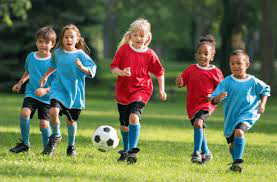

In [8]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
 
# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature
 
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text
 
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model('model-ep003-loss3.660-val_loss3.884.h5')
# load and prepare the photograph
photo = extract_features('example1.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.open('example1.jpg')
print(description.replace('startseq','').replace('endseq',''))
image

## Testing our Model for Random Images

 two children are playing in the water 


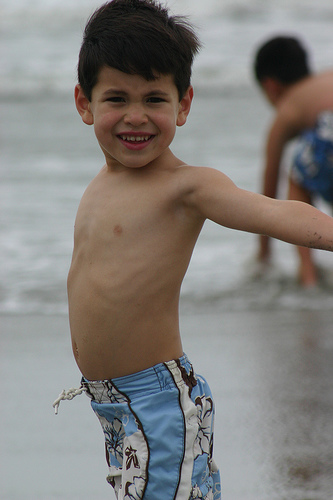

In [31]:
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
photo = extract_features('eg1.jpg'.format(i))
description = generate_desc(model, tokenizer, photo, max_length)
image = Image.open('eg1.jpg'.format(i))
print(description.replace('startseq','').replace('endseq',''))
image

 dog is running through the water 


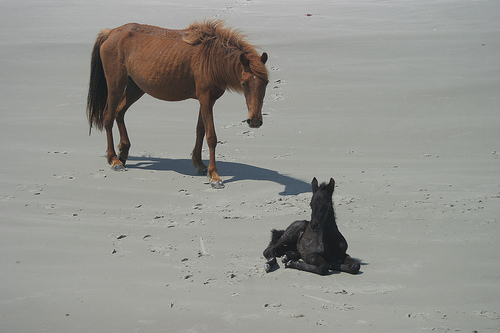

In [33]:
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
photo = extract_features('eg3.jpg'.format(i))
description = generate_desc(model, tokenizer, photo, max_length)
image = Image.open('eg3.jpg'.format(i))
print(description.replace('startseq','').replace('endseq',''))
image

 man riding bike on dirt road 


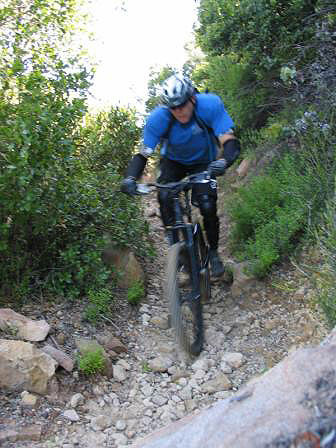

In [34]:
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
photo = extract_features('eg4.jpg'.format(i))
description = generate_desc(model, tokenizer, photo, max_length)
image = Image.open('eg4.jpg'.format(i))
print(description.replace('startseq','').replace('endseq',''))
image

##  Conclusion

1. Our Model performs reasonably well looking by the captions it generated.
2. Due to limited computing capability, we could only train for 5 epochs, ideally we would have wanted to train over 20 epochs for better accuracy.